# Random forest regression

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

import pickle

### Data loading

In [3]:
#We load the cleaned dataset (the one where NaN were replaced by the minute average of the missing variable)
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite_minute_mean_na.csv", sep=',', parse_dates=["DateTime"])

In [4]:
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091514e+00,1.237063e-01,2.408396e+02,4.627338e+00,1.121462e+00,1.298511e+00,6.459688e+00
std,1.051782e+00,1.120370e-01,3.223413e+00,4.421231e+00,6.115164e+00,5.786107e+00,8.393276e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390100e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.160000e-01,1.020000e-01,2.410000e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.526000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### Data preprocessing

In [7]:
timeframe = "3h" #Timeframe we will average on. Time steps will be steps of that length
delta_t_seconds=0 #This variable is the number of seconds of the specified timeframe (used later on). example: 60*60 for a resample('h')

timeframe = timeframe.lower()
if(timeframe == "15min"):
    delta_t_seconds = 60*15
elif(timeframe == "1h"):
    delta_t_seconds = 60*60
elif(timeframe == "3h"):
    delta_t_seconds = 60*60*3
else:
    print("Timeframe not supported")


df_rf = df.set_index('DateTime')
df_rf = df_rf.resample(timeframe).mean() #We average each variable over the specified timeframe
df_rf['Date'] = pd.to_datetime(df_rf.index.date)
df_rf.head(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date
DateTime,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,2006-12-16
2006-12-16 18:00:00,3.433667,0.080122,233.961389,14.673333,0.0,2.716667,16.777778,2006-12-16
2006-12-16 21:00:00,2.439400,0.068089,238.846111,10.488889,0.0,0.211111,7.216667,2006-12-16


In [9]:
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
temperatures.head(3)

,min_t,max_t,avg_t
Date,,,
2006-01-02,3.0,7.6,2.30
2006-01-03,3.9,6.8,1.45
2006-01-04,4.5,6.9,1.20


In [10]:
df_rf = df_rf.join(temperatures, how="left", on='Date') #Adding temperatures columns
df_rf = df_rf.drop(columns=['Date','avg_t', 'Voltage', 'Global_intensity']) #We drop avg_t, voltage, and intensity because they give no new information (and we suspect voltage's measurements to be wrong/inaccurate after seeing it's distribution)
# df_rf = df_rf[["Global_active_power", "min_t", "max_t"]]
df_rf.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t
DateTime,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5


In [11]:
# These columns are essential for the model, because time of the day, day of the week, and month of the year heavily impact the power consumption.
df_rf["Hour"] = df_rf.index.hour + df_rf.index.minute/60
df_rf["Day"] = df_rf.index.dayofweek
df_rf["Month"] = df_rf.index.month
df_rf.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,
2006-12-16 15:00:00,4.222889,0.229000,0.0,0.527778,16.861111,0.3,9.5,15.0,5,12
2006-12-16 18:00:00,3.433667,0.080122,0.0,2.716667,16.777778,0.3,9.5,18.0,5,12
2006-12-16 21:00:00,2.439400,0.068089,0.0,0.211111,7.216667,0.3,9.5,21.0,5,12


In [12]:
# Check if there are any NaNs in the data
print(df_rf.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
min_t                    0
max_t                    0
Hour                     0
Day                      0
Month                    0
dtype: int64


### Creating a Validation set

In [13]:
# dataset de validation qu'on garde dans l'ordre chronologique, pour tester une fois le modele entrainé avec le reste des données shuffled
validation_size = 0.008

df_val = None
if(validation_size != 0.0):
    n_rows_val_set = round(df_rf.shape[0]*validation_size)
    print(f"Taille du validation set : {n_rows_val_set}")

    df_val = df_rf.iloc[-n_rows_val_set:]
    df_rf = df_rf.iloc[:-n_rows_val_set]
    print("Train set shape : ", df_val.shape)
    print("Validation set shape : ", df_rf.shape)

Taille du validation set : 92
Train set shape :  (92, 10)
Validation set shape :  (11439, 10)


### Scaling

In [14]:
columns_not_to_scale=["Hour", "Day", "Month"] #these columns are not scaled, to allow for easy incrementation later on
columns_to_scale = list(df_rf.columns)
for col in columns_not_to_scale:
    if(col in columns_to_scale):
        columns_to_scale.remove(col)


scaler = MinMaxScaler(feature_range=(-1,1))
df_rf[columns_to_scale] = scaler.fit_transform(df_rf[columns_to_scale])
df_rf.describe()

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
count,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000,11439.000000
mean,-0.653061,-0.698133,-0.913698,-0.922700,-0.352713,0.143172,0.024577,10.499869,3.001574,6.414547
std,0.287355,0.193282,0.196330,0.188526,0.610898,0.361932,0.379078,6.874450,2.001398,3.405382
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000
25%,-0.902866,-0.827395,-1.000000,-0.986801,-0.873678,-0.117460,-0.250633,4.500000,1.000000,3.000000
50%,-0.712174,-0.743270,-1.000000,-0.980201,-0.544240,0.155556,0.037975,9.000000,3.000000,6.000000
75%,-0.472789,-0.633396,-0.997007,-0.968322,0.104619,0.441270,0.321519,16.500000,5.000000,9.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,6.000000,12.000000


In [15]:
#We don't fit the scaler on the validation data set to avoid data leakage
df_val[columns_to_scale] = scaler.transform(df_val[columns_to_scale])
df_val.head(3)

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,min_t,max_t,Hour,Day,Month
DateTime,,,,,,,,,,
2010-11-15 12:00:00,-0.245870,-0.668865,-1.000000,0.083650,0.111297,0.320635,-0.113924,12.0,0,11
2010-11-15 15:00:00,-0.838615,-0.907406,-1.000000,-0.973272,-1.000000,0.320635,-0.113924,15.0,0,11
2010-11-15 18:00:00,-0.330357,-0.798480,-0.787043,-0.969312,-0.486923,0.320635,-0.113924,18.0,0,11


The next function reorganizes the dataset to make it suited for supervised learning. A column is added that holds the value for the next time frame of the value we want to predict.

In [16]:
def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    columns = []
    columns.append(data.shift(1))
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

### Random Forest modeling

For one variable :

In [17]:
def create_train_model(model_type, df_rf, y_col="Global_active_power", train_size = 0.8, shuffle=True, n_estimators=500, learning_rate=0.1):
    df = df_rf.copy()

    df = data_to_supervised(df, y_col)
    y_col = y_col + '(t)'

    X = df.drop(columns=[y_col])
    y = df[y_col]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=train_size, shuffle=shuffle, random_state = 1)

    model = None
    if(model_type == "RandomForestRegressor"):
        model = RandomForestRegressor(n_estimators = n_estimators, random_state = 1)
    elif(model_type == "GradientBoostingRegressor"):
        model = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate=learning_rate, random_state = 1)
    else:
        return 0
    
    model.fit(train_X, train_y)

    ypred = model.predict(test_X)
    
    r2 = r2_score(test_y, ypred)
    r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
    mse = mean_squared_error(test_y, ypred)
    rmse = np.sqrt(mse)

    scores = {}
    scores['r2'] = r2
    scores['r_adjusted'] = r_adjusted
    scores['mse'] = mse
    scores['rmse'] = rmse

    return model, scores
    

In [18]:
def plot_val_set_predictions(df_val, model, scaler, y_col, nbr_steps=0):
    val_X = df_val.copy()

    descaled_val = df_val.copy()
    descaled_val[columns_to_scale] = scaler.inverse_transform(descaled_val[columns_to_scale])
    val_y = descaled_val[y_col] #actual y
    val_y = val_y.append(pd.Series([np.nan]))

    names = [col + "(t-1)" for col in val_X.columns]
    val_X.columns = names

    val_ypred = model.predict(val_X)
    val_ypred = np.insert(val_ypred, 0, np.nan)
    nbr_steps = len(val_ypred)
    fake_df_for_descaling = pd.DataFrame(np.zeros((nbr_steps, len(list(val_X.columns)))), columns=df_val.columns)
    fake_df_for_descaling[y_col] = list(val_ypred)
    fake_df_for_descaling[columns_to_scale] = scaler.inverse_transform(fake_df_for_descaling[columns_to_scale])
    val_ypred = fake_df_for_descaling["Global_active_power"].tolist()

    if(nbr_steps == 0):
        nbr_steps = len(val_ypred)
    aa=[x for x in range(nbr_steps)]
    plt.figure(figsize=(40,10))
    plt.title("One step prediction over the dataset")
    plt.plot(aa, val_y[:nbr_steps], marker='.', label="actual")
    plt.plot(aa, val_ypred[:nbr_steps], 'r', label="prediction")
    plt.ylabel(df.columns[1], size=15)
    plt.xlabel('Time steps', size=15)
    plt.legend(fontsize=15)
    plt.show()

Test of the 2 functions above

In [ ]:
# y_col = "Global_active_power"

# model, scores= create_train_model("RandomForestRegressor", df_rf, y_col, train_size = 0.5, shuffle=True, n_estimators=500)
# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
# print(f"Test MSE: {scores['mse']}")
# print(f"Test RMSE: {scores['rmse']}")

In [ ]:
# plot_val_set_predictions(df_val, model, scaler, y_col)

Creation and training of models for each variable of the dataset, in order to be able to predict a full new row of the dataset (and later use it to further predict one more step in time)

In [19]:
def create_models_all_var(model_type, df_rf, train_size=0.8, shuffle=True, n_estimators=500, learning_rate=0.1, verbose=False):
    non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
    models = {}
    for col in df_rf.columns:
        if(col not in non_predictable_vars):
            if(verbose):
                print(f"Training a model on predicting the {col} variable")
                model, scores = create_train_model(model_type, df_rf, col, train_size, shuffle, n_estimators=n_estimators, learning_rate=learning_rate)
            model_and_scores = {}
            model_and_scores["model"] = model
            model_and_scores["scores"] = scores
            models[col] = model_and_scores

    return models

Training of the models :

In [20]:
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
models = create_models_all_var(model_type[0], df_rf, train_size=0.8, shuffle=True, n_estimators=500, learning_rate=0.12, verbose=True)

Training a model on predicting the Global_active_power variable
Training a model on predicting the Global_reactive_power variable
Training a model on predicting the Sub_metering_1 variable
Training a model on predicting the Sub_metering_2 variable
Training a model on predicting the Sub_metering_3 variable


In [21]:
#scores of models trained above
for variable in models.keys():
    print(f"\nScores for the model trained to predict {variable}:")
    print(f"R-squared: {models[variable]['scores']['r2']}")
    print(f"Adjusted R-squared: {models[variable]['scores']['r_adjusted']}")
    print(f"Test MSE: {models[variable]['scores']['mse']}")
    print(f"Test RMSE: {models[variable]['scores']['rmse']}")


Scores for the model trained to predict Global_active_power:
R-squared: 0.5764636493209713
Adjusted R-squared: 0.5746035862964696
Test MSE: 0.036892383925754134
Test RMSE: 0.19207390225055077

Scores for the model trained to predict Global_reactive_power:
R-squared: 0.43833393922001196
Adjusted R-squared: 0.43586724593595405
Test MSE: 0.0206563789287022
Test RMSE: 0.1437232720498048

Scores for the model trained to predict Sub_metering_1:
R-squared: 0.15556251339436455
Adjusted R-squared: 0.15185396053267974
Test MSE: 0.030516780339522626
Test RMSE: 0.1746905273319725

Scores for the model trained to predict Sub_metering_2:
R-squared: 0.20536311631016968
Adjusted R-squared: 0.20187327492374085
Test MSE: 0.02977693457426566
Test RMSE: 0.17255994487211004

Scores for the model trained to predict Sub_metering_3:
R-squared: 0.4783449793319232
Adjusted R-squared: 0.4760540042740924
Test MSE: 0.1938041909451822
Test RMSE: 0.4402319740150438


The following functions make multistep forecasting/prediction possible: predicted rows are used as inputs again, to make new predictions recursively.

In [22]:
def predict_all_variables(models, x_row, temperatures_predictions, timesteps_forward=1, delta_t_seconds=60*60*1):
    date = datetime.datetime.fromisoformat(str(x_row.index[0]))

    rows = x_row.copy()
    names = [col + "(t-1)" for col in rows.columns]
    rows.columns = names
    for i in range(timesteps_forward):
        date = date + datetime.timedelta(seconds=delta_t_seconds)
        prediction = []
        for model_name in models.keys():
            last_line = pd.DataFrame(rows.iloc[rows.shape[0]-1]).transpose()
            prediction.append(models[model_name].predict(last_line)[0])
        prediction.append(temperatures_predictions.loc[str(date)]["min_t"])
        prediction.append(temperatures_predictions.loc[str(date)]["max_t"])
        prediction.append(date.hour + date.minute/60)
        prediction.append(date.weekday())
        prediction.append(date.month)

        prediction = pd.Series(prediction, index = names)
        rows = rows.append(prediction, ignore_index=True)

    rows = rows.drop(index=0)#drop the first initial row, used to start the predictions
    return rows

In [23]:
# This function loads the models from disk and uses them to predict multiple steps, given a row of inputs
def forecast(initial_row, temperatures_predictions, model_type = "RandomForestRegressor", timesteps_forward=1, timeframe="3h"):
    delta_t_seconds=0
    timeframe = timeframe.lower()
    if(timeframe == "15min"):
        delta_t_seconds = 60*15
    elif(timeframe == "1h"):
        delta_t_seconds = 60*60
    elif(timeframe == "3h"):
        delta_t_seconds = 60*60*3
    else:
        print("Timeframe not supported")
        return 0
    
    models = {}
    for var in initial_row.columns:
        non_predictable_vars = ["min_t", "max_t", "avg_t", "Hour", "Day", "Month"]
        if(var not in non_predictable_vars):
            try:
                models[var] = pickle.load(open(f'models/{timeframe}/{model_type}/{var}.pkl', 'rb'))
            except:
                print(f"Model for variable {var} was not found on disk.")
                return 0
    
    predictions = predict_all_variables(models, initial_row, temperatures_predictions, timesteps_forward, delta_t_seconds)

    return predictions

In [24]:
# This function predicts multiple steps given a date (it will look for the data at that specific date in the dataset)
def forecast_from_row_dataset(initial_date, df, temperatures_predictions, model_type = "RandomForestRegressor", timesteps_forward=1, timeframe="3h"):
    initial_date = str(datetime.datetime.fromisoformat(initial_date))#je passe en datetime uniquement pour verifier que la date est bien à un format valide. ça levera une exception sinon
    if(not initial_date in df.index):
        print(f"The date given ({initial_date}) was not found in the dataset")
    initial_row = pd.DataFrame(df.loc[initial_date]).transpose()

    predictions = forecast(initial_row, temperatures_predictions, model_type=model_type, timesteps_forward=timesteps_forward, timeframe=timeframe)
    
    return predictions

Prediction tests and graphs on the validation set :

In [25]:
first_day_valset = df_val.iloc[0].name
print(f"Starting datetime of the validation set : {str(first_day_valset)}")

Starting datetime of the validation set : 2010-11-15 12:00:00


In [46]:
df_to_use = df_val.copy()

nbr_predictions = 50
initial_date = "2010-11-15 12:00:00"
model_type = ["RandomForestRegressor", "GradientBoostingRegressor"]
temperatures_predictions = df_val[["min_t", "max_t"]]

#Making multistep prediction.The only information we get from reality is the first row of inputs
predictions = forecast_from_row_dataset(initial_date, df_to_use, temperatures_predictions, model_type[0], nbr_predictions, timeframe)

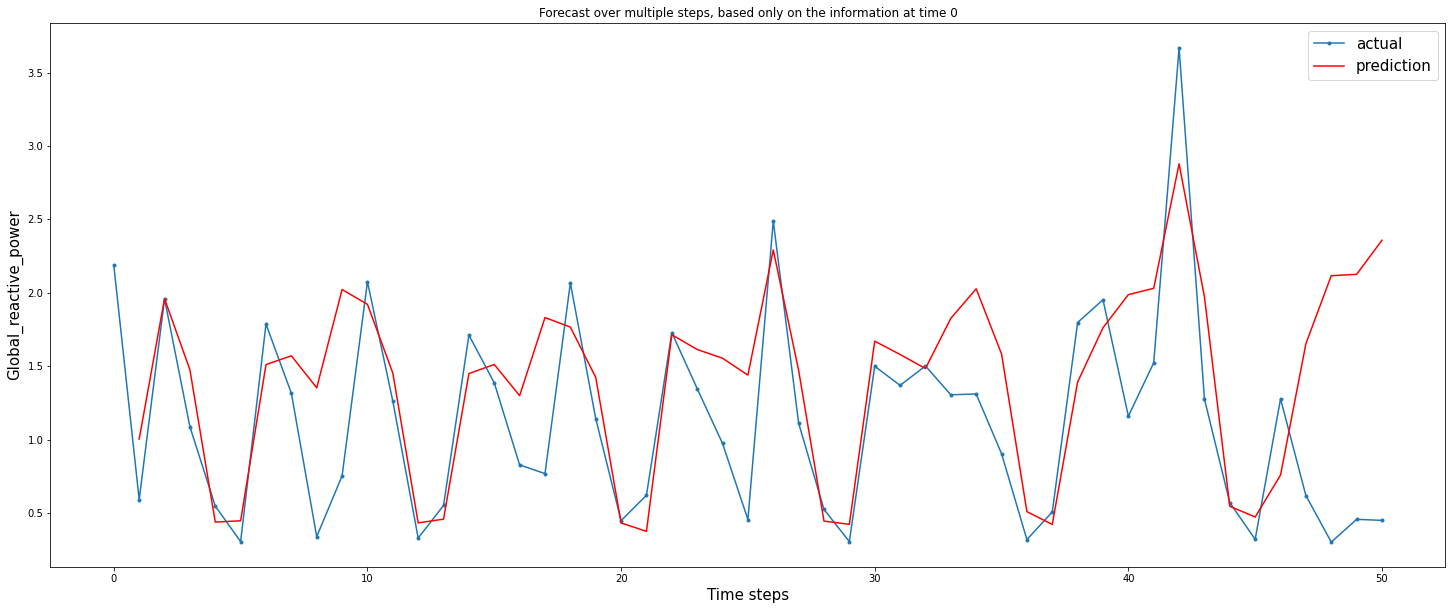

Validation MSE: 0.4225984320984329
Validation RMSE: 0.650075712589259


In [47]:
# Plotting the results vs reality:


initial_date_dt = datetime.datetime.fromisoformat(initial_date)

descaled_df = df_to_use.copy()
descaled_df[columns_to_scale] = scaler.inverse_transform(descaled_df[columns_to_scale])

y = descaled_df.loc[(descaled_df.index >= str(initial_date_dt)) & (descaled_df.index < str(initial_date_dt+datetime.timedelta(seconds=delta_t_seconds*(nbr_predictions+1))))]["Global_active_power"]
yhat = predictions["Global_active_power(t-1)"]
yhat = pd.concat([pd.Series([np.nan]), yhat])


fake_df_for_descaling = pd.DataFrame(np.zeros((len(yhat), len(list(df_to_use.columns)))), columns=df_val.columns)
fake_df_for_descaling["Global_active_power"] = list(yhat)
fake_df_for_descaling[columns_to_scale] = scaler.inverse_transform(fake_df_for_descaling[columns_to_scale])
yhat = fake_df_for_descaling["Global_active_power"].tolist()

#Graph of Actual Global_active_power and predicted Global_active_power together to compare
nbr_steps = len(yhat)
aa=[x for x in range(nbr_steps)]
plt.figure(figsize=(25,10))
plt.title("Forecast over multiple steps, based only on the information at time 0")
plt.plot(aa, y[:nbr_steps], marker='.', label="actual")
plt.plot(aa, yhat[:nbr_steps], 'r', label="prediction")
plt.ylabel(df_to_use.columns[1], size=15)
plt.xlabel(f'Time steps', size=15)
plt.legend(fontsize=15)
plt.show()

#Scores of this recursive prediciton :
y = y.tolist()
y.pop(0)
yhat.pop(0)

# r2 = r2_score(y, yhat)
# r_adjusted = 1 - ( 1-r2 ) * ( len(y) - 1 ) / ( len(y) - initial_row.shape[1] - 1 )
mse = mean_squared_error(y, yhat)
rmse = np.sqrt(mse)

scores = {}
# scores['r2'] = r2
# scores['r_adjusted'] = r_adjusted
scores['mse'] = mse
scores['rmse'] = rmse

# print(f"R-squared: {scores['r2']}")
# print(f"Adjusted R-squared: {scores['r_adjusted']}")
print(f"Validation MSE: {scores['mse']}")
print(f"Validation RMSE: {scores['rmse']}")

Predictions are of course most accurate for the first hours/time steps (closer to the last real data input), but even after, they don't diverge much over time and do a good job at staying realistic and close to real data, even days after last real data input !

Graph of predictions, only one prediction per real data row (not multistep) :

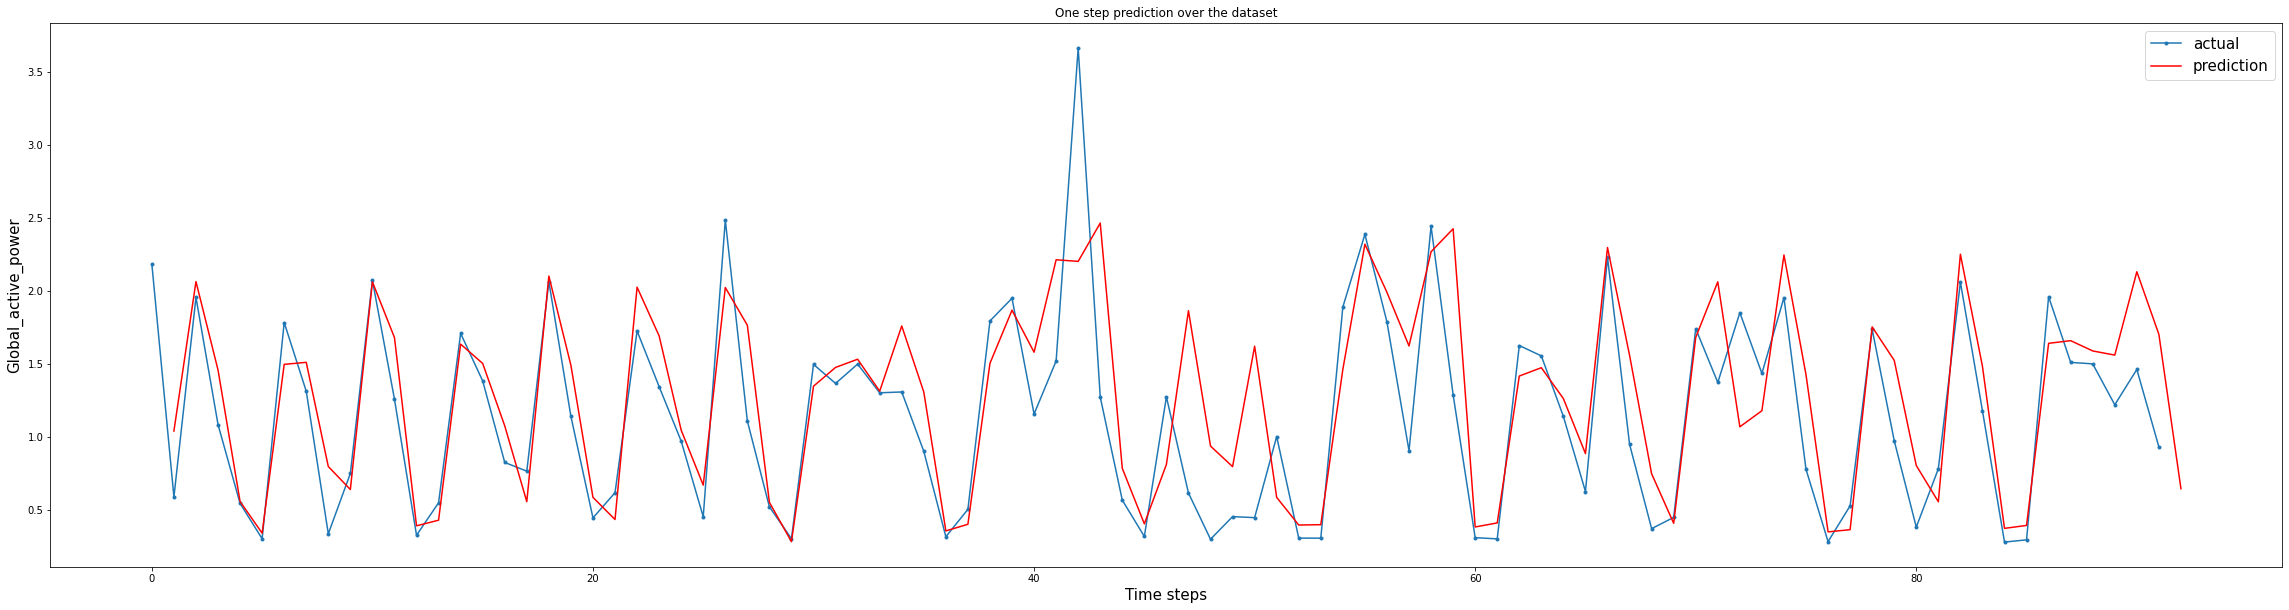

In [40]:
plot_val_set_predictions(df_val, models["Global_active_power"]["model"], scaler, "Global_active_power")

The graph above shows the prediction results when the model is given real data at each step. It predicts only one step ahead each time. 

Serializing the trained models to be able to use them later

In [ ]:
#serialize models
model_type = models[list(models.keys())[0]]['model'].__class__.__name__
path = f"models/{timeframe}/{model_type}/"
for variable in models.keys():
    if(not os.path.exists(path)):
        os.makedirs(path)
    filename =f"{path}{variable}.pkl"
    pickle.dump(models[variable]["model"], open(filename, 'wb'))
    print(f"'{variable}' predicting model saved on disk as {filename}")

In [ ]:
#serialize scaler
filename =f"{path}scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'))
print(f"Scaler saved on disk as {filename}")